In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [13]:
# Load data
df = pd.read_csv("acl_cartography.csv")
with open("acl_cartography_stats.json", "r", encoding="utf-8") as f:
    stats = json.load(f)

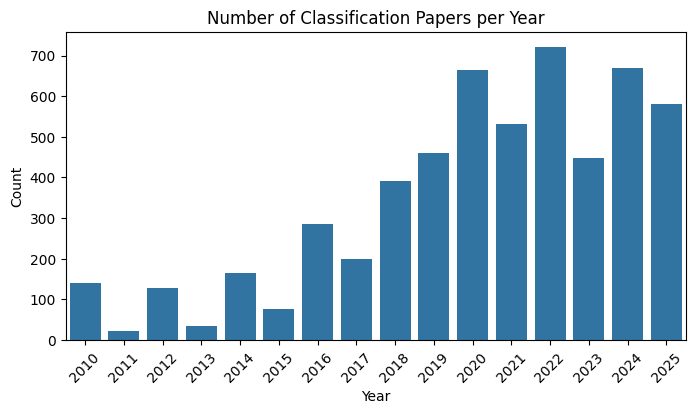

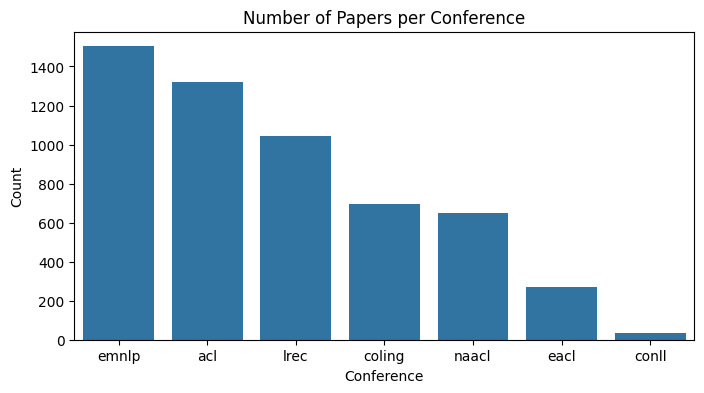

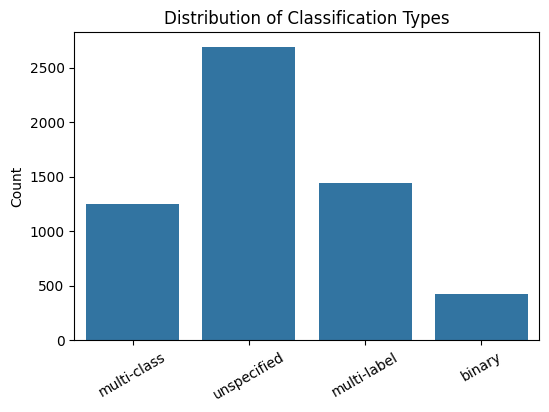

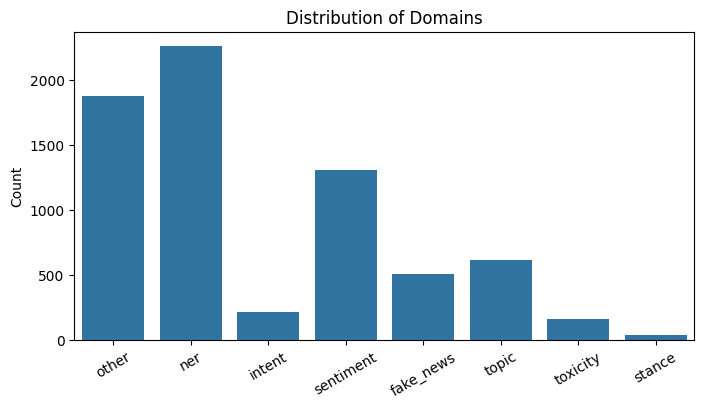

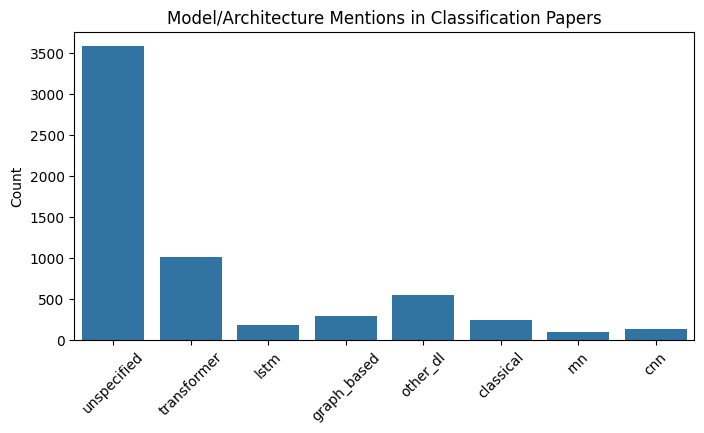

In [14]:
# --- Plot 1: Papers by Year ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["papers_by_year"].keys()), y=list(stats["papers_by_year"].values()))
plt.title("Number of Classification Papers per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# --- Plot 2: Papers by Conference ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["papers_by_conference"].keys()), y=list(stats["papers_by_conference"].values()))
plt.title("Number of Papers per Conference")
plt.xlabel("Conference")
plt.ylabel("Count")
plt.show()

# --- Plot 3: Classification Type Distribution ---
plt.figure(figsize=(6,4))
sns.barplot(x=list(stats["classification_types_dist"].keys()), y=list(stats["classification_types_dist"].values()))
plt.title("Distribution of Classification Types")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# --- Plot 4: Domains Distribution ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["domains_dist"].keys()), y=list(stats["domains_dist"].values()))
plt.title("Distribution of Domains")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# --- Plot 5: Model Type Distribution ---
plt.figure(figsize=(8,4))
sns.barplot(x=list(stats["models_dist"].keys()), y=list(stats["models_dist"].values()))
plt.title("Model/Architecture Mentions in Classification Papers")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()